# Disclaimer : Model อาจจะเบิ้มคือลือเกินไป ควรใช้ colab เพราะคอมเจ้าของยังกากเลย

# Ep:02 Iris Flower to Iris

### ยินดีตอนรับ commander อีกครั้ง
ในซ่อมแซมครั้งนี้เป็นเรื่องของระบบดวงตาของ doll <br>
เพื่อกูคืนระบบดวงตาให้กับ doll ให้เร็วที่สุด <br>

เราต้องใช้ Convolutional Neural Network (CNN) ในการทำนายรูปภาพดอก iris ว่าเป็น iris ชนิดใด<br>
เราจะใช้ข้อมูล iris รูปสี 3 ชนิด คือ iris-setosa, iris-versicolor, iris-virginica

จำนวน 421 รูปภาพ ขนาด 256x256x3 pixel

In [ ]:
#!/bin/bash
%pip install kaggle
!kaggle datasets download jeffheaton/iris-computer-vision

Dataset URL: https://www.kaggle.com/datasets/jeffheaton/iris-computer-vision
License(s): GNU Lesser General Public License 3.0
 94% 5.00M/5.33M [00:00<00:00, 35.7MB/s]
100% 5.33M/5.33M [00:00<00:00, 37.3MB/s]


Unzip เองนะครับ

In [ ]:
#!/bin/bash
!mkdir /content/iris
!unzip /content/iris-computer-vision.zip -d /content/iris

Archive:  /content/iris-computer-vision.zip
  inflating: /content/iris/iris-setosa/iris-01ab65973fd487a6cee4c5af1551c42b264eec5abab46bffd7c307ffef647e11.jpg  
  inflating: /content/iris/iris-setosa/iris-0797945218a97d6e5251b4758a2ba1b418cbd52ce4ef46a3239e4b939bd9807b.jpg  
  inflating: /content/iris/iris-setosa/iris-0c826b6f4648edf507e0cafdab53712bb6fd1f04dab453cee8db774a728dd640.jpg  
  inflating: /content/iris/iris-setosa/iris-0ff5ba898a0ec179a25ca217af45374fdd06d606bb85fc29294291facad1776a.jpg  
  inflating: /content/iris/iris-setosa/iris-1289c57b571e8e98e4feb3e18a890130adc145b971b7e208a6ce5bad945b4a5a.jpg  
  inflating: /content/iris/iris-setosa/iris-16f7515e1d6aa6d7dd3af4bca38c8065bfab9d426c5fd75b3c4bc51d737fb9d0.jpg  
  inflating: /content/iris/iris-setosa/iris-1e80d2d6f3e9cf96c1cb33f3e47f3e5a3f4a6eb26fa3ab479d462e1ac837ba66.jpg  
  inflating: /content/iris/iris-setosa/iris-1f941001f508ff1bd492457a90da64e52c461bfd64587a3cf7c6bf1bcb35adab.jpg  
  inflating: /content/iris/iris-seto

In [ ]:
!nvidia-smi

Sun Jan 19 10:13:37 2025       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   42C    P8               9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

### requirements
- keras/tensorflow
- matplotlib
- numpy

### ข้อมูล model
- ใช้ Convolutional Neural Network (CNN) ในการทำนายรูปภาพดอก iris ว่าเป็น iris ชนิดใด
- ใช้ architecture ตามใจในการสร้าง model
- เลือกใช้ loss function เป็น categorical_crossentropy
- เลือกใช้ optimizer กับ learning ตามที่เหมาะสม

In [ ]:
from __future__ import print_function

import datetime
import keras
import numpy as np
import random
import tensorflow as tf
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten,BatchNormalization,Input,AveragePooling2D
from keras.layers import Conv2D, MaxPooling2D
from keras import backend as K

In [ ]:
import os
def set_seed(seed_value=1234):
    random.seed(seed_value)
    np.random.seed(seed_value)
    tf.random.set_seed(seed_value)
    os.environ['PYTHONHASHSEED'] = str(seed_value)
set_seed(426969)

### Dataloader and normalization

การทำ Dataloader จำเป็นต้องต้องทำการกำหนดค่าของแต่ละชนิดก่อน

 - image_dataset_from_directory function : ทำให้สามารถ loaddata หลาย class ได้ในที่เดียว
```python
keras.utils.image_dataset_from_directory(
                                              directory,
                                             shuffle=True,
                                             batch_size=BATCH_SIZE,
                                             image_size=IMG_SIZE,
                                             validation_split=0.2,
                                             subset='training' or 'validation',
                                             seed=42)
)
```

In [ ]:
BATCH_SIZE = 10
IMG_SIZE = (224, 224)

In [ ]:
train_dest = keras.utils.image_dataset_from_directory(
                                          "/content/iris",
                                          shuffle=True,
                                          batch_size=BATCH_SIZE,
                                          color_mode="rgb",
                                          image_size=IMG_SIZE,
                                          validation_split=0.2,
                                          subset='training',
                                          seed = 426969)

Found 421 files belonging to 3 classes.
Using 337 files for training.


In [ ]:
valid_dset = keras.utils.image_dataset_from_directory(
                                          "/content/iris",
                                          shuffle=True,
                                          batch_size=BATCH_SIZE,
                                          color_mode="rgb",
                                          image_size=IMG_SIZE,
                                          validation_split=0.2,
                                          subset='validation',
                                          seed = 426969)

Found 421 files belonging to 3 classes.
Using 84 files for validation.


In [ ]:
class_names = train_dest.class_names
class_names

['iris-setosa', 'iris-versicolour', 'iris-virginica']

In [ ]:
for images, labels in valid_dset.take(1):
    print(images.shape)  # Should print (batch_size, 224, 224, 3)
    print(labels.shape)  # Should print (batch_size,)

(10, 224, 224, 3)
(10,)


### Train section

#### architecture
* feature layer :
    3 Conv2D 32,64,128 (3,3)  
    2 AveragePooling2D (2,2)
* FC : Dense 256 1x

In [ ]:
model = Sequential([
    Input(shape=(224, 224, 3)),
    BatchNormalization(),
    Conv2D(32, (3, 3), activation='relu'),
    MaxPooling2D(),  # Pool size of 2x2
    Dropout(0.2),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(),
    Dropout(0.2),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(),
    Flatten(),  # Converts feature maps into a 1D vector
    Dropout(0.2),
    Dense(256, activation='relu'),
    Dense(len(class_names), activation='softmax')  # Ensure len(class_names) matches your dataset
])

sparse_categorical_crossentropy vs categorical_crossentropy

index endcoding | one-hot endcoding

In [ ]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [ ]:
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ batch_normalization_2                │ (None, 224, 224, 3)         │              12 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_6 (Conv2D)                    │ (None, 222, 222, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_6 (MaxPooling2D)       │ (None, 111, 111, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 111, 111, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 109, 109, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_7 (MaxPooling2D)       │ (None, 54, 54, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 54, 54, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_8 (Conv2D)                    │ (None, 52, 52, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_8 (MaxPooling2D)       │ (None, 26, 26, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_2 (Flatten)                  │ (None, 86528)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 86528)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 256)                 │      22,151,424 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 3)                   │             771 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 22,245,455 (84.86 MB)

 Trainable params: 22,245,449 (84.86 MB)

 Non-trainable params: 6 (24.00 B)

In [ ]:
print('GPU name: ', tf.config.experimental.list_physical_devices('GPU'))
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

GPU name:  [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Num GPUs Available:  1


In [ ]:
history = model.fit(train_dest, validation_data=valid_dset, epochs=200)

Epoch 1/200
34/34 ━━━━━━━━━━━━━━━━━━━━ 11s 166ms/step - accuracy: 0.5162 - loss: 5.1445 - val_accuracy: 0.6548 - val_loss: 1.0350
Epoch 2/200
34/34 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - accuracy: 0.6324 - loss: 0.9185 - val_accuracy: 0.6548 - val_loss: 0.9827
Epoch 3/200
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - accuracy: 0.6725 - loss: 0.8330 - val_accuracy: 0.6190 - val_loss: 0.9980
Epoch 4/200
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.6570 - loss: 0.8212 - val_accuracy: 0.6190 - val_loss: 0.8600
Epoch 5/200
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - accuracy: 0.7355 - loss: 0.6435 - val_accuracy: 0.6786 - val_loss: 0.9657
Epoch 6/200
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - accuracy: 0.7533 - loss: 0.5673 - val_accuracy: 0.5833 - val_loss: 0.9903
Epoch 7/200
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.8766 - loss: 0.2897 - val_accuracy: 0.5000 - val_loss: 1.2773
Epoch 8/200
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.9366 - loss: 0.2465 - val_accuracy: 

In [ ]:
y_prediction = model.predict(valid_dset)

9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step


In [ ]:
import sklearn
true_categories = tf.concat([y for x, y in valid_dset], axis=0)
predicted_categories = tf.argmax(y_prediction, axis=1)
report = sklearn.metrics.classification_report(true_categories,predicted_categories)
print(report)

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        10
           1       0.67      0.93      0.78        55
           2       0.00      0.00      0.00        19

    accuracy                           0.61        84
   macro avg       0.22      0.31      0.26        84
weighted avg       0.44      0.61      0.51        84



9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


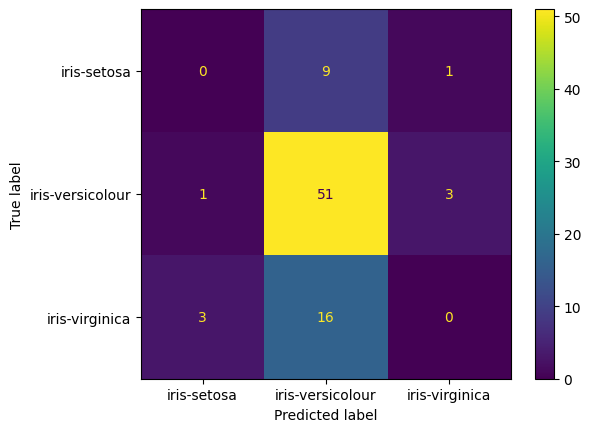

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
y_prediction = model.predict(valid_dset)
confusion_matrix = confusion_matrix(true_categories, predicted_categories)
predicted_categories = tf.argmax(y_prediction, axis=1)
Display = sklearn.metrics.ConfusionMatrixDisplay(confusion_matrix= confusion_matrix,display_labels=train_dest.class_names)
Display.plot()
plt.show()